In [1]:
import numpy as np
import mne
import os

In [2]:
import tensorflow as tf
tf.keras.backend.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print('Successful')
    except RuntimeError as e:
        print(e)

Successful


In [3]:
real_unProcessed_data = np.load('F:\\Personal Projects\\Seizure Prediction\\SeizureDetection\\Data\\NumpyData\\NonEpileptic\\non_preprocessed_data.npy')
real_unProcessed_data.shape

(73275, 23, 640)

In [4]:
data_files = []

allFiles = []

with open('F:\\Personal Projects\\Seizure Prediction\\SeizureDetection\\Data\\RawData\\RECORDS') as f:
    for line in f:
        if line.strip().endswith('.edf') and '+' not in line.strip():
            allFiles.append(line.strip())

seizureFiles = []

nonSeizureFiles = [file for file in allFiles if file not in seizureFiles]

with open('F:\\Personal Projects\\Seizure Prediction\\SeizureDetection\\Data\\RawData\\RECORDS-WITH-SEIZURES') as f:
    for line in f:
        if line.strip().endswith('.edf') and '+' not in line:
            seizureFiles.append(line.removesuffix('\n'))

def get_raw():
    for item in nonSeizureFiles:
        raw = mne.io.read_raw_edf(os.path.join('F:\\Personal Projects\\Seizure Prediction\\SeizureDetection\\Data\\RawData', item))
        if raw.info['nchan'] == 23:
            data_files.append(os.path.join('F:\\Personal Projects\\Seizure Prediction\\SeizureDetection\\Data\\RawData', item))
            break
    
    return raw

raw = get_raw()

Extracting EDF parameters from F:\Personal Projects\Seizure Prediction\SeizureDetection\Data\RawData\chb01\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\Sunny\AppData\Local\Temp\ipykernel_13972\4250845362.py:21: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(os.path.join('F:\\Personal Projects\\Seizure Prediction\\SeizureDetection\\Data\\RawData', item))


In [5]:
print(raw.ch_names)

['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']


Creating RawArray with float64 data, n_channels=23, n_times=640
    Range : 0 ... 639 =      0.000 ...     4.992 secs
Ready.
Using matplotlib as 2D backend.


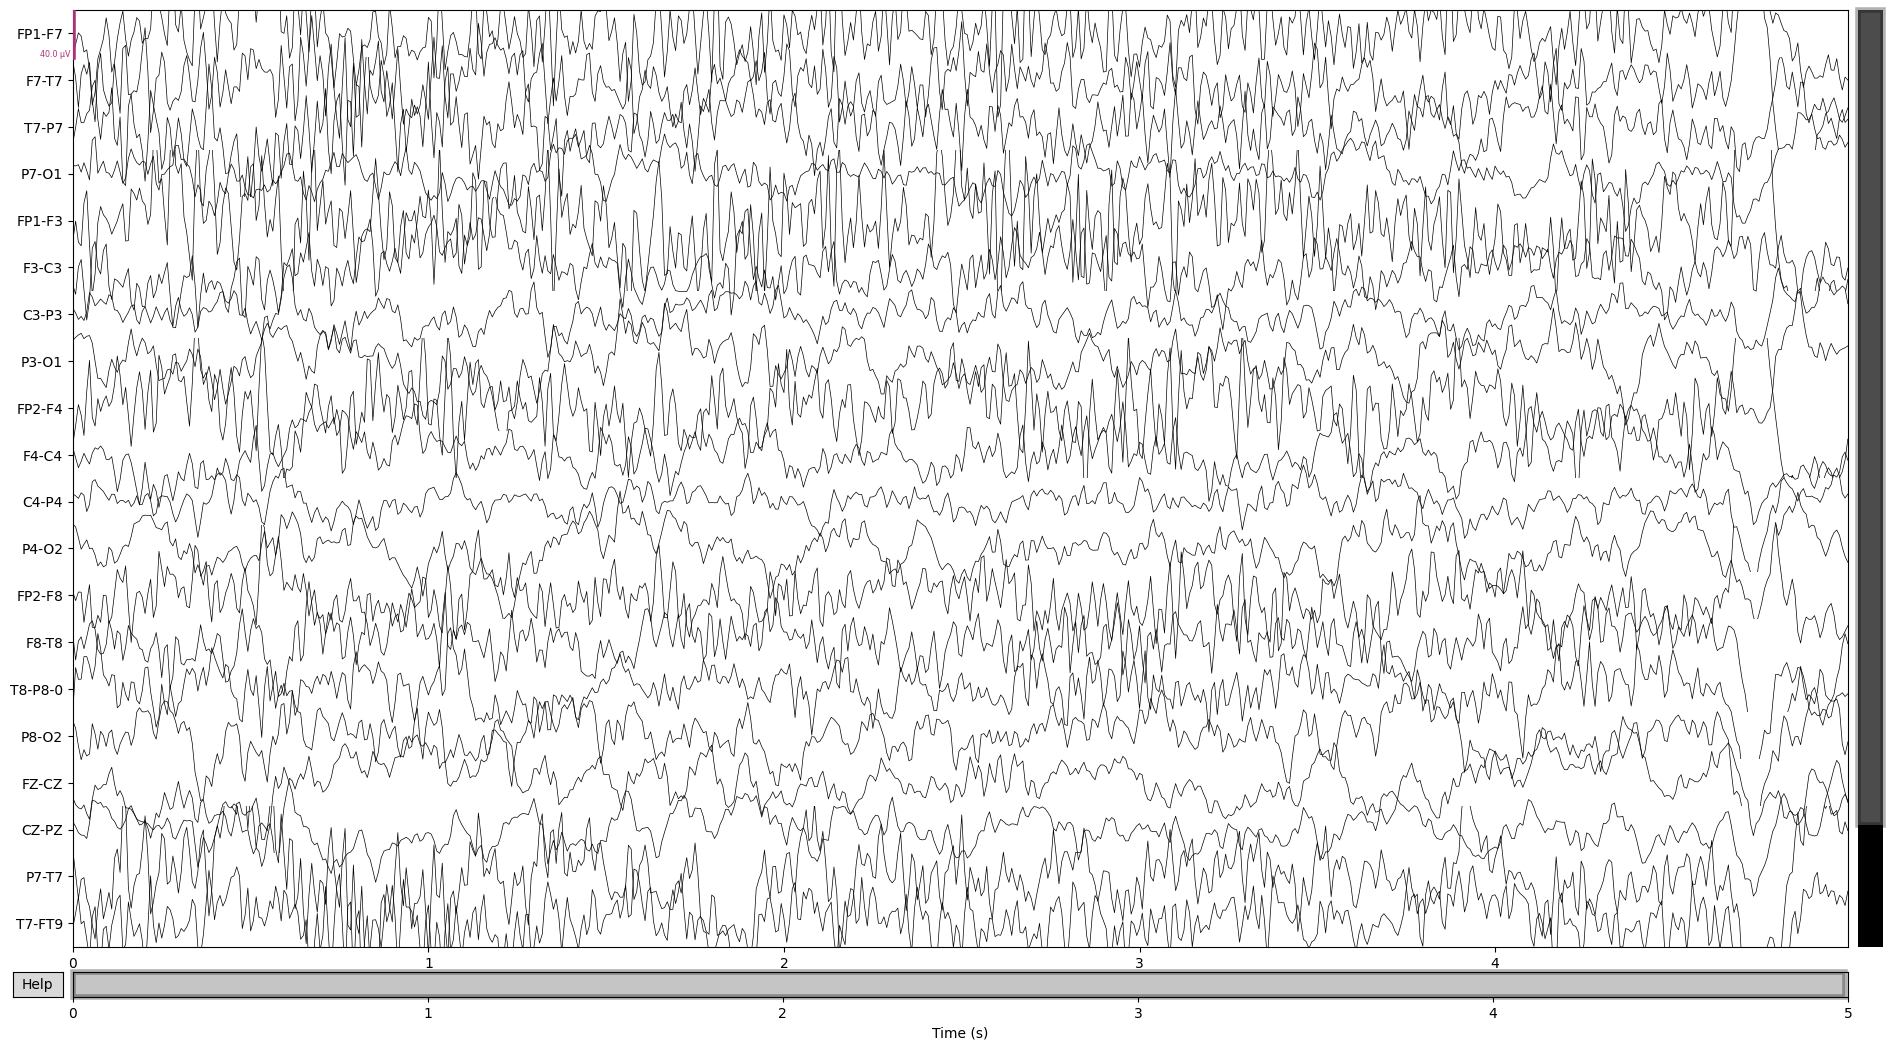

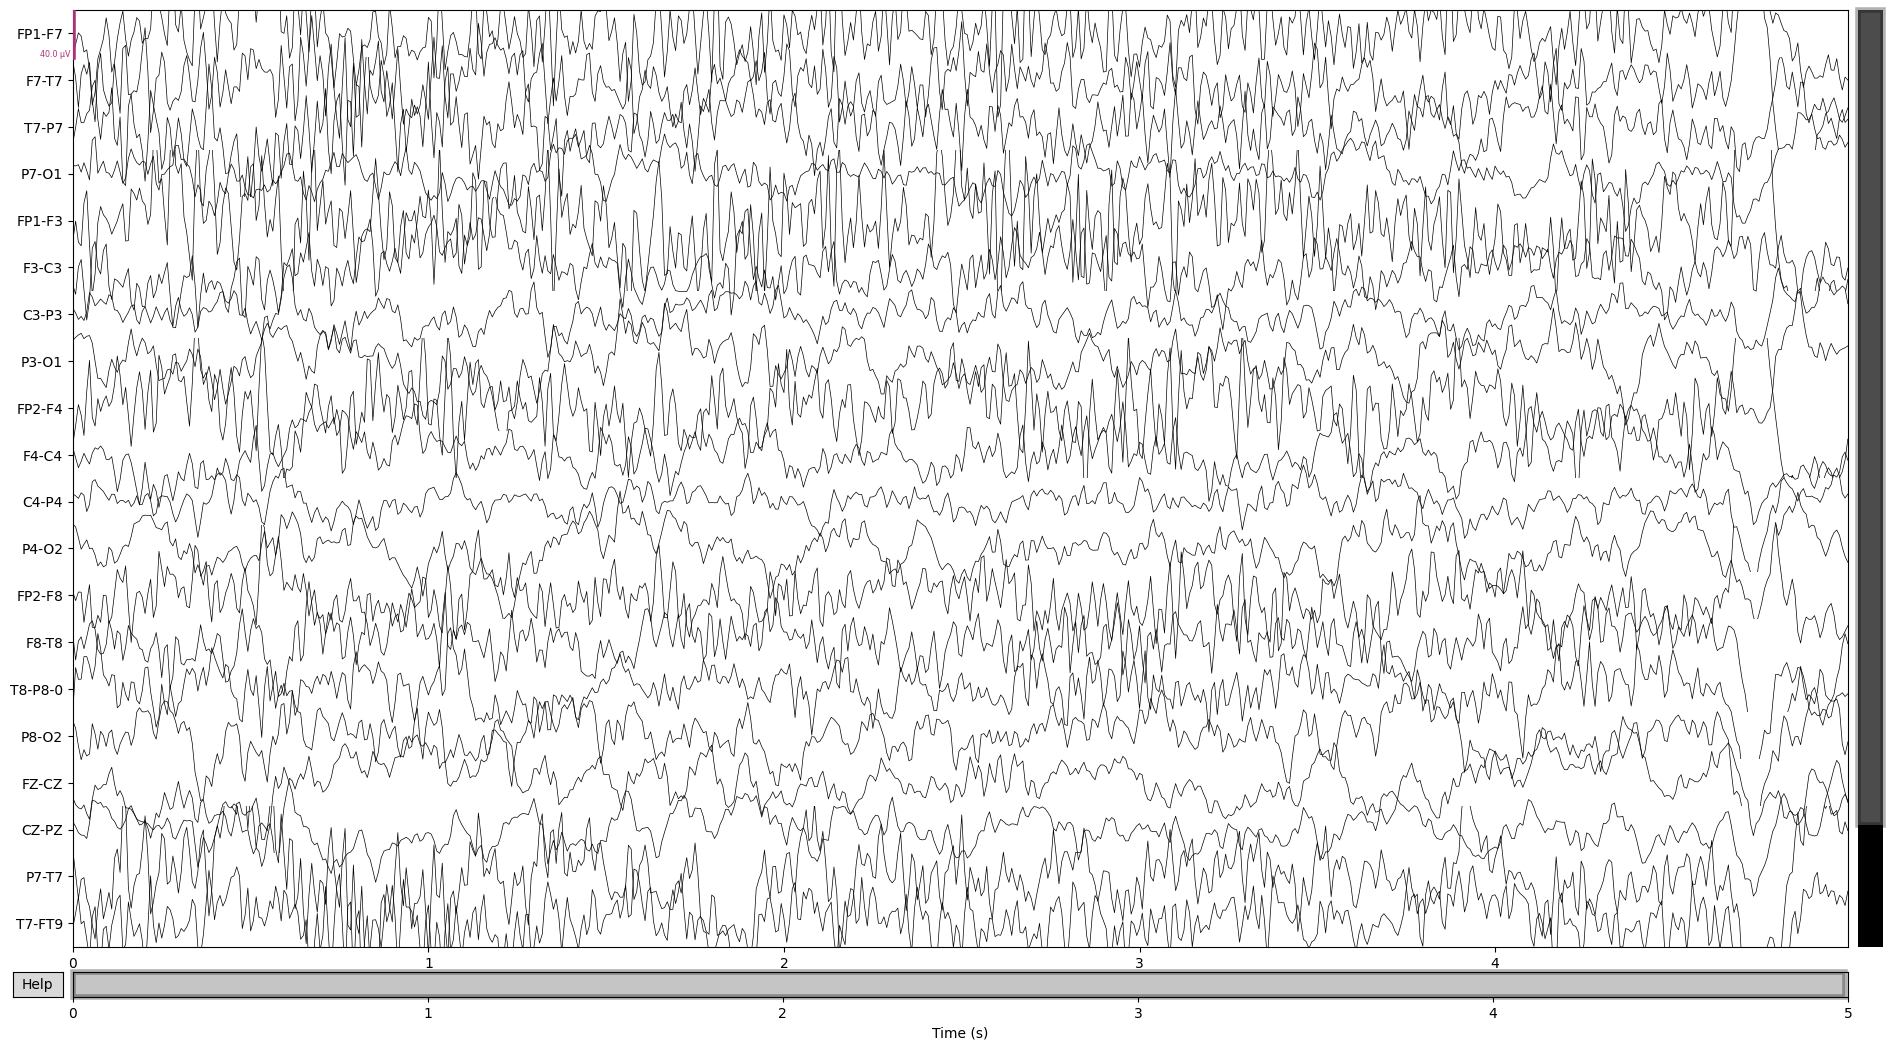

In [6]:
data = np.asarray(real_unProcessed_data[4].T)
new_data = mne.io.RawArray(data.transpose(), info = mne.create_info(ch_names=raw.ch_names, sfreq=128, ch_types='eeg'))
new_data.plot()

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import LSTM, Dense, Reshape, LeakyReLU, Dropout, UpSampling1D, Flatten, BatchNormalization, MaxPooling1D, TimeDistributed, RepeatVector, Conv1D, Input, Conv1DTranspose, LayerNormalization

In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [10]:
def build_generator():
    model = Sequential()

    model.add(Dense(128, input_shape=(640, 23)))  # Decrease the number of neurons
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))  # Adjusted dropout rate

    model.add(LSTM(16, return_sequences=True))  # Decrease the number of LSTM units
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(UpSampling1D())

    model.add(Conv1D(1024, kernel_size=3, strides=2, padding='same'))  # Decrease the number of filters
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(UpSampling1D())

    model.add(Conv1D(512, kernel_size=3, strides=2, padding='same'))  # Decrease the number of filters
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(UpSampling1D())

    model.add(Conv1D(256, kernel_size=3, strides=2, padding='same'))  # Decrease the number of filters
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(UpSampling1D())

    model.add(Conv1D(128, kernel_size=3, strides=2, padding='same'))  # Decrease the number of filters
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(UpSampling1D())

    model.add(Conv1D(64, kernel_size=3, strides=2, padding='same'))  # Decrease the number of filters
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    model.add(LSTM(23, return_sequences=True))

    return model

In [11]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 640, 128)          3072      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 640, 128)          0         
                                                                 
 dropout (Dropout)           (None, 640, 128)          0         
                                                                 
 lstm (LSTM)                 (None, 640, 16)           9280      
                                                                 
 batch_normalization (BatchN  (None, 640, 16)          64        
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 640, 16)           0         
                                                        

In [12]:
import matplotlib.pylab as plt

In [13]:
a = generator.predict(np.random.randn(4, 640, 23))

1/1 [==============================] - 4s 4s/step


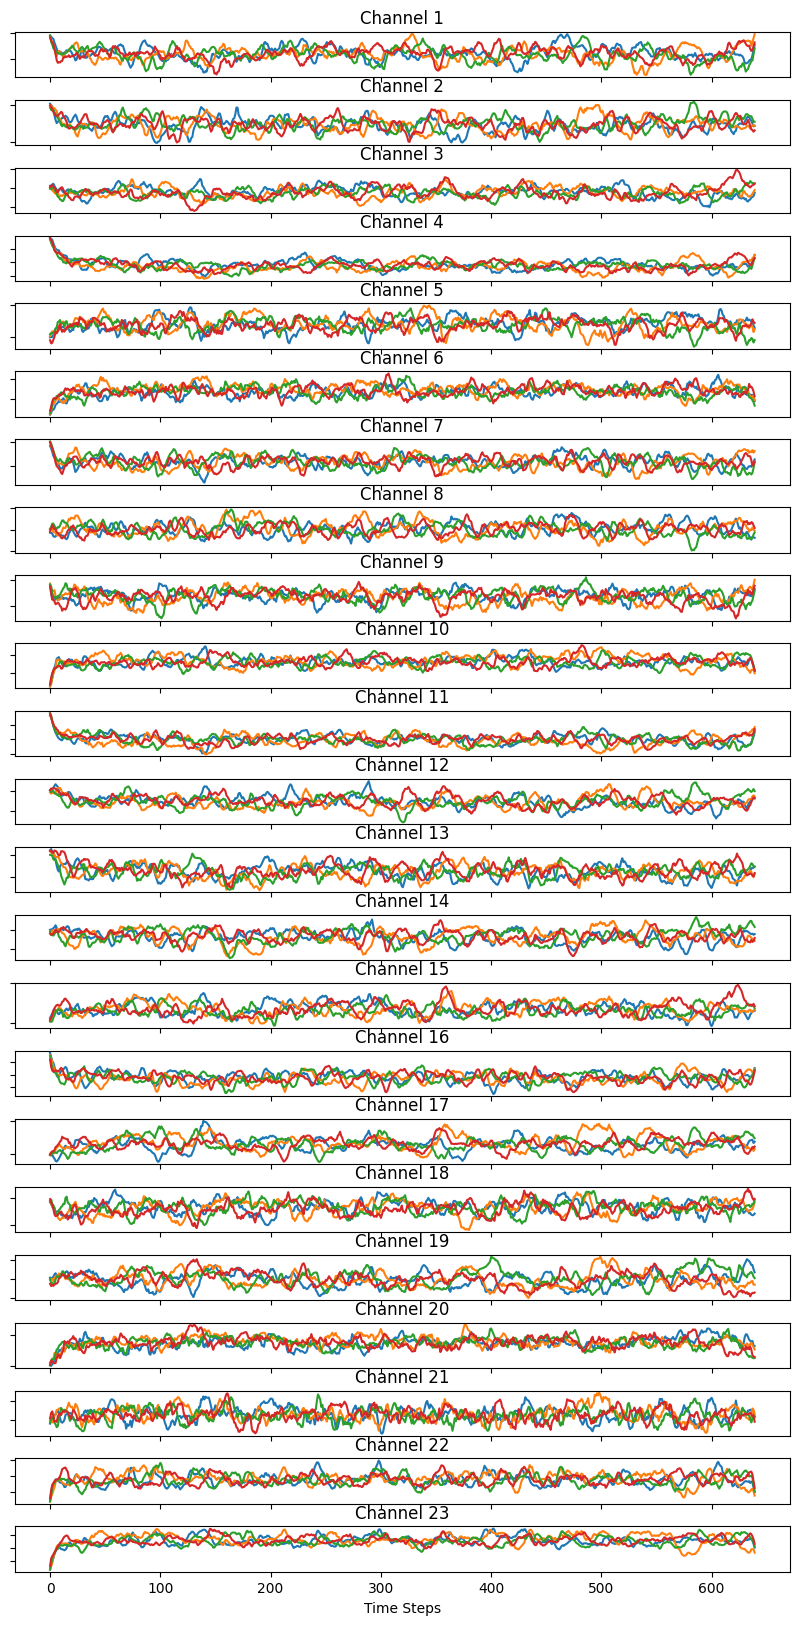

In [14]:
fig, ax = plt.subplots(nrows=a.shape[2], figsize=(10, 20), sharex=True, gridspec_kw={'wspace': 0.5})

for channel in range(a.shape[2]):
    for sample in range(a.shape[0]):
        ax[channel].plot(a[sample, :, channel])  # Plot each sample
    ax[channel].set_title(f'Channel {channel + 1}')

    # Hide y-axis labels
    ax[channel].set_yticklabels([])

# Hide x-axis labels
ax[-1].set_xlabel('Time Steps')

# Add vertical spacing
plt.subplots_adjust(hspace=0.5)
plt.show()

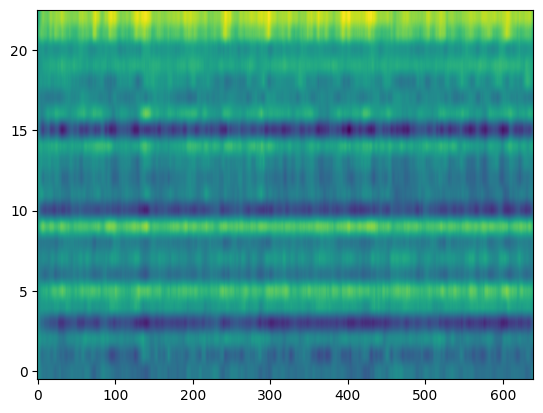

In [15]:
plt.imshow(a[0].T, aspect='auto', cmap='viridis')
plt.gca().invert_yaxis()
plt.show()

In [16]:
def build_discriminator(input_shape):
    model = Sequential()

    model.add(Conv1D(64, kernel_size=3, strides=2, input_shape=input_shape, padding='same'))  # Decrease the number of filters
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    model.add(Conv1D(128, kernel_size=3, strides=2, padding='same'))  # Decrease the number of filters
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Conv1D(256, kernel_size=3, strides=2, padding='same'))  # Decrease the number of filters
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Conv1D(512, kernel_size=3, strides=2, padding='same'))  # Decrease the number of filters
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Conv1D(1024, kernel_size=3, strides=2, padding='same'))  # Decrease the number of filters
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(LSTM(16, return_sequences=True))  # Decrease the number of LSTM units
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [17]:
input_shape = (640, 23)
discriminator = build_discriminator(input_shape)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 320, 64)           4480      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 320, 64)           0         
                                                                 
 batch_normalization_6 (Batc  (None, 320, 64)          256       
 hNormalization)                                                 
                                                                 
 conv1d_6 (Conv1D)           (None, 160, 128)          24704     
                                                                 
 batch_normalization_7 (Batc  (None, 160, 128)         512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 160, 128)         

In [18]:
discriminator.predict(a)

1/1 [==============================] - 1s 625ms/step


array([[0.49995935],
       [0.49994993],
       [0.49991858],
       [0.49993157]], dtype=float32)

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback

In [20]:
g_opt = Adam(learning_rate=0.001)
d_opt = Adam(learning_rate=0.06)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [21]:
real_unProcessed_data.shape

(73275, 23, 640)

In [22]:
def lmfao():
    for item in real_unProcessed_data[1:1601]:
        yield item

ds = tf.data.Dataset.from_generator(lmfao, output_signature=tf.TensorSpec(shape=(23, 640), dtype=tf.float32))
ds = ds.shuffle(12800)
ds = ds.batch(8)
ds = ds.prefetch(8)

In [23]:
ds.element_spec

TensorSpec(shape=(None, 23, 640), dtype=tf.float32, name=None)

In [24]:
import matplotlib
import matplotlib.pyplot as plt


class ModelMonitor(Callback):
    def __init__(self, num_samples=8, latent_dim=640):
        self.num_samples = num_samples
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = np.random.randn(self.num_samples, self.latent_dim, 23)
        generated_EEG_data = self.model.generator.predict(random_latent_vectors)
        generated_EEG_data = np.asarray(generated_EEG_data)

        info = mne.create_info(ch_names=raw.ch_names, sfreq=128, ch_types='eeg')

        save_path = 'F:\\Personal Projects\\Seizure Prediction\\SeizureDetection\\Data\\GENERATED_DATA'

        for i in range(self.num_samples):
            data = np.asarray(generated_EEG_data[i])
            new_data = mne.io.RawArray(data.transpose(), info)

            epoch_path = os.path.join(save_path, f'epoch_{epoch+1}')

            if not os.path.exists(epoch_path):
                os.mkdir(epoch_path)

            raw_path = os.path.join(epoch_path, 'raw')
            if not os.path.exists(raw_path):
                os.mkdir(raw_path)

            plot_path = os.path.join(epoch_path, 'plot')
            if not os.path.exists(plot_path):
                os.mkdir(plot_path)

            # Plotting raw data
            _, ax = plt.subplots(data.shape[1], 1, figsize=(10, 2*data.shape[1]))
            for channel in range(data.shape[1]):
                ax[channel].plot(data[:, channel])
                ax[channel].set_yticklabels([])
            ax[-1].set_xlabel('Time Steps')
            plt.subplots_adjust(hspace=0.5)
            plt.savefig(os.path.join(plot_path, f'sample_{i+1}.png'))
            plt.close("all")

            # Plotting MNE data
            new_data.plot(scalings='auto', show=False)
            plt.savefig(os.path.join(raw_path, f'sample_{i+1}.png'))
            plt.close("all")

In [25]:
class EpilepticGAN(Model):
    def __init__(self, generator, discriminator, ip=(640, 23), *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator
        self.ip = ip

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.g_loss = g_loss
        self.d_opt = d_opt
        self.d_loss = d_loss

    def train_step(self, batch):
        real_EEG_data = batch
        real_EEG_data = tf.reshape(real_EEG_data, [-1, 640, 23])

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            fake_EEG_data = self.generator(tf.random.normal(shape=(8, 640, 23)), training=False)
            yhat_real = self.discriminator(real_EEG_data, training=True)
            yhat_fake = self.discriminator(fake_EEG_data, training=True)
            yhat_real_fake = tf.concat([yhat_real, yhat_fake], axis=0)

            y_real_fake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            noise_real = 0.2 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.2 * tf.random.uniform(tf.shape(yhat_fake))
            y_real_fake += tf.concat([noise_real, noise_fake], axis=0)

            total_d_loss = self.d_loss(y_real_fake, yhat_real_fake)

        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            fake_EEG_data = self.generator(tf.random.normal(shape=(8, 640, 23)), training=True)
            predicted_labels = self.discriminator(fake_EEG_data, training=False)

            total_g_loss = self.g_loss(tf.ones_like(predicted_labels), predicted_labels)

        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"g_loss": total_g_loss, "d_loss": total_d_loss}


In [26]:
gan = EpilepticGAN(generator=generator, discriminator=discriminator, ip=(8, 640, 23))

In [27]:
gan.compile(g_opt = g_opt, d_opt = d_opt, g_loss = g_loss, d_loss = d_loss)

In [28]:
%matplotlib agg

hist = gan.fit(ds, epochs=100,callbacks=[ModelMonitor()],verbose = 1)

Epoch 1/100


1/1 [==============================] - 0s 56ms/step d_loss: 0.43
Creating RawArray with float64 data, n_channels=23, n_times=640
    Range : 0 ... 639 =      0.000 ...     4.992 secs
Ready.
Creating RawArray with float64 data, n_channels=23, n_times=640
    Range : 0 ... 639 =      0.000 ...     4.992 secs
Ready.
Creating RawArray with float64 data, n_channels=23, n_times=640
    Range : 0 ... 639 =      0.000 ...     4.992 secs
Ready.
Creating RawArray with float64 data, n_channels=23, n_times=640
    Range : 0 ... 639 =      0.000 ...     4.992 secs
Ready.
Creating RawArray with float64 data, n_channels=23, n_times=640
    Range : 0 ... 639 =      0.000 ...     4.992 secs
Ready.
Creating RawArray with float64 data, n_channels=23, n_times=640
    Range : 0 ... 639 =      0.000 ...     4.992 secs
Ready.
Creating RawArray with float64 data, n_channels=23, n_times=640
    Range : 0 ... 639 =      0.000 ...     4.992 secs
Ready.
Creating RawArray with float64 data, n_channels=23, n_times=

In [29]:
plt.plot(hist.history['g_loss'], label='Generator Loss')
plt.plot(hist.history['d_loss'], label='Discriminator Loss')
plt.savefig('training_plot.png')

In [30]:
gan.generator.save('generator_prototype_1-0-0.h5')

In [31]:
gan.discriminator.save('discriminator_prototype_1-0-0.h5')